# Importing

## Importing modules

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop

## Importing own code

In [73]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [74]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [75]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [76]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [77]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2]))#, kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2]))#, kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

# Getting data

## Importing data and settings

In [78]:
filename = 'databaseModLen_min_cut0.90_widths86_Width1.5-10_data50k_3-1sur_epoch30_maxDelta0.1_R020_M2M3M4M5Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3, -4, -5]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize=4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [79]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues
0,2252,"[[4.5353838354, 4.0540062074], [7.6140483522, ...",9.9,3,-1.315147,"[-33187.2120197838, -93.8800097279, 114.125604..."
1,2253,"[[8.7952107494, 8.5889648161], [5.5668325193, ...",10.0,3,-1.315149,"[-915.6188099523, -176.6664326259, 6.798013776..."
2,2254,"[[2.5456988216000003, 4.2395446585], [1.682321...",10.0,3,-1.059135,"[-64510.856218194, -24.0594903883, 45.16763496..."
3,2255,"[[8.0428135394, 3.0268027076], [8.6424053055, ...",10.0,3,-0.453253,"[-892.5768876505, -79.1172175211, 32.888387337..."
4,2256,"[[5.9090835247, 3.6590882915], [5.9637839272, ...",10.0,3,-1.314386,"[-77148.11781282, -54.4631750034, 75.420055691..."


In [80]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,31521.000000,31521.000000,31521.0,31521.000000
mean,15760.000000,4.678008,3.0,4.203249
std,9099.473254,2.068157,0.0,65.557457
min,0.000000,1.500000,3.0,-45.142848
25%,7880.000000,3.000000,3.0,-4.392354
50%,15760.000000,4.500000,3.0,-1.825203
75%,23640.000000,6.100000,3.0,-0.800430
max,31520.000000,10.000000,3.0,2665.287506


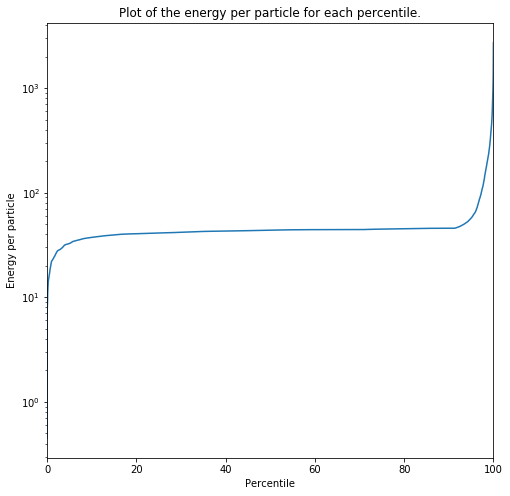

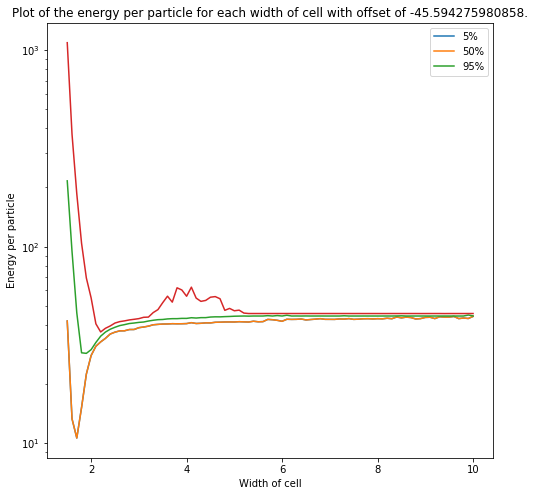

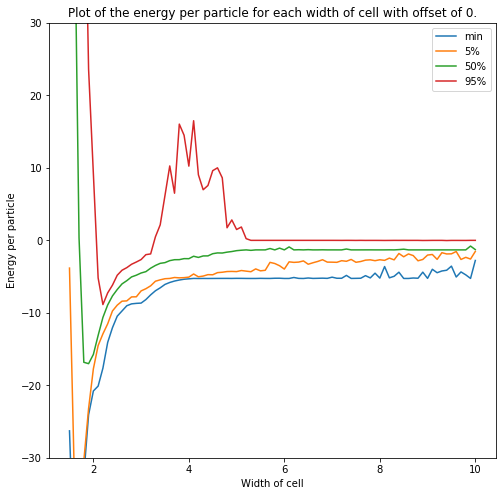

In [81]:
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()


#"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

#"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


## Preparing data

In [100]:
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(np.array(trainingData['eigenvalues'][i]))
    #targetData.append(trainingData['potentialEnergy'][i])
    targetData.append(sum(trainingData['eigenvalues'][i]))
    #targetData.append(0)

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

[print(trainingInput['input'][i], trainingInput['target'][i], '\n \n') for i in range(0, 10)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(np.array(validationData['eigenvalues'][i]))
    #targetData.append(validationData['potentialEnergy'][i])
    targetData.append([sum(validationData['eigenvalues'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

[-1.53711532e+03 -1.28209566e+03  5.63092529e+02  5.37369880e+03
 -5.82746445e+04 -4.59671573e+04  3.64897071e+04  8.34678997e+04
 -2.23134177e+06 -1.64639670e+06  1.57038375e+06  2.40882313e+06
 -8.59054936e+07 -5.89355965e+07  5.85756885e+07  8.69990874e+07] 853987.6296633929 
 

[-1.40197943e+03 -9.73025891e+02 -8.23892730e+02  1.32674894e+04
 -4.49007937e+04 -2.60604222e+04 -1.96983435e+04  1.62637776e+05
 -1.37726914e+06 -6.74351829e+05 -4.44273314e+05  3.21157857e+06
 -4.12668879e+07 -1.72406049e+07 -9.62812608e+06  7.63398689e+07] 9001981.15257527 
 

[-1.36116694e+04 -2.66450880e+03  3.55249280e+03  1.50261752e+04
 -1.58784188e+06 -1.37099502e+05  1.42284892e+05  1.59327650e+06
 -1.85240807e+08 -7.06385002e+06  7.09450367e+06  1.85271692e+08
 -2.16107691e+10 -3.64105252e+08  3.64303260e+08  2.16109674e+10] 470763.0854072571 
 

[-1.45343513e+04 -4.01242694e+03  4.56401125e+03  1.53415598e+04
 -1.75213505e+06 -2.53991523e+05  2.56618547e+05  1.75488112e+06
 -2.11229565e+08 -1.60

## Preparing test data

No handles with labels found to put in legend.


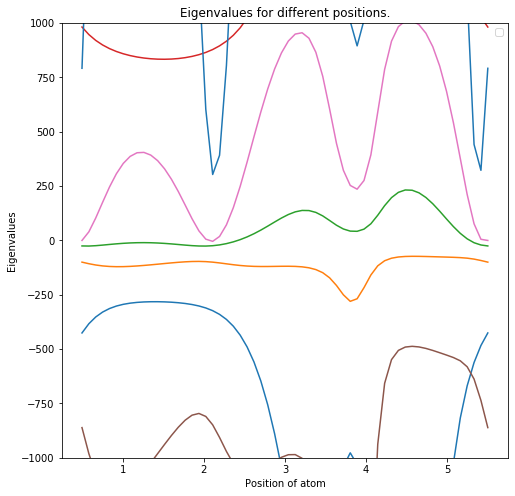

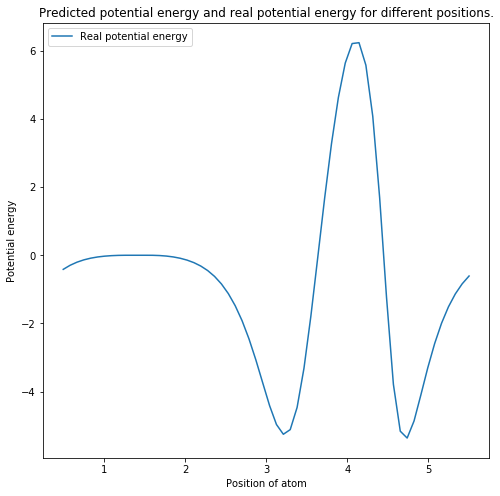

In [84]:
#"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-1000, 1000)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()


# Machine learning

In [85]:
models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = 'MAE'#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))

## Model 0: Linear network

In [143]:
name = 'LinearNetwork'
settings = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-2

#model = makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform')#, lossFunction=lossMetric)#eras.initializers.glorot_uniform(seed=None)
model = Sequential()
#model.add(Dense(12, input_dim=16, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(1, input_dim=16, use_bias=False))
model.add(Activation("relu"))
opt = SGD(lr=learningRate)
model.compile(loss='MAE', optimizer=opt)
newWeights = np.array([[[1] for j in range(16)]])
print(np.shape(newWeights))
print(np.shape(model.layers[0].get_weights()))
model.layers[0].set_weights(newWeights)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())
    print(model.evaluate(validationInput['input'], validationInput['target'], verbose=0))

(1, 16, 1)
(1, 16, 1)
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 1)                 16        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)]
9544.141380992638
Layer 1:  []
9544.141380992638


Train on 17651 samples, validate on 7566 samples
Epoch 1/30
17651/17651 [==============================] - 1s 61us/step - loss: 618288.2802 - val_loss: 646848.4673
Epoch 2/30
17651/17651 [==============================] - 1s 61us/step - loss: 618706.3889 - val_loss: 646848.4673
Epoch 3/30
17651/17651 [==============================] - 1s 58us/step - loss: 618706.3916 - val_loss: 646848.4673
Epoch 4/30
17651/17651 [==============================] - 1s 59us/step - loss: 618706.3901 - val_loss: 646848.4673
Epoch 5/30
17651/17651 [==============================] - 1s 63us/step - loss: 618706.3899 - val_loss: 646848.4673
Epoch 6/30
17651/17651 [==============================] - 1s 61us/step - loss: 618706.3909 - val_loss: 646848.4673
Epoch 7/30
17651/17651 [==============================] - 1s 59us/step - loss: 618706.3913 - val_loss: 646848.4673
Epoch 8/30
17651/17651 [==============================] - 1s 57us/step - loss: 618706.3905 - val_loss: 646848.4673
Epoch 9/30
17651/17651 [=======

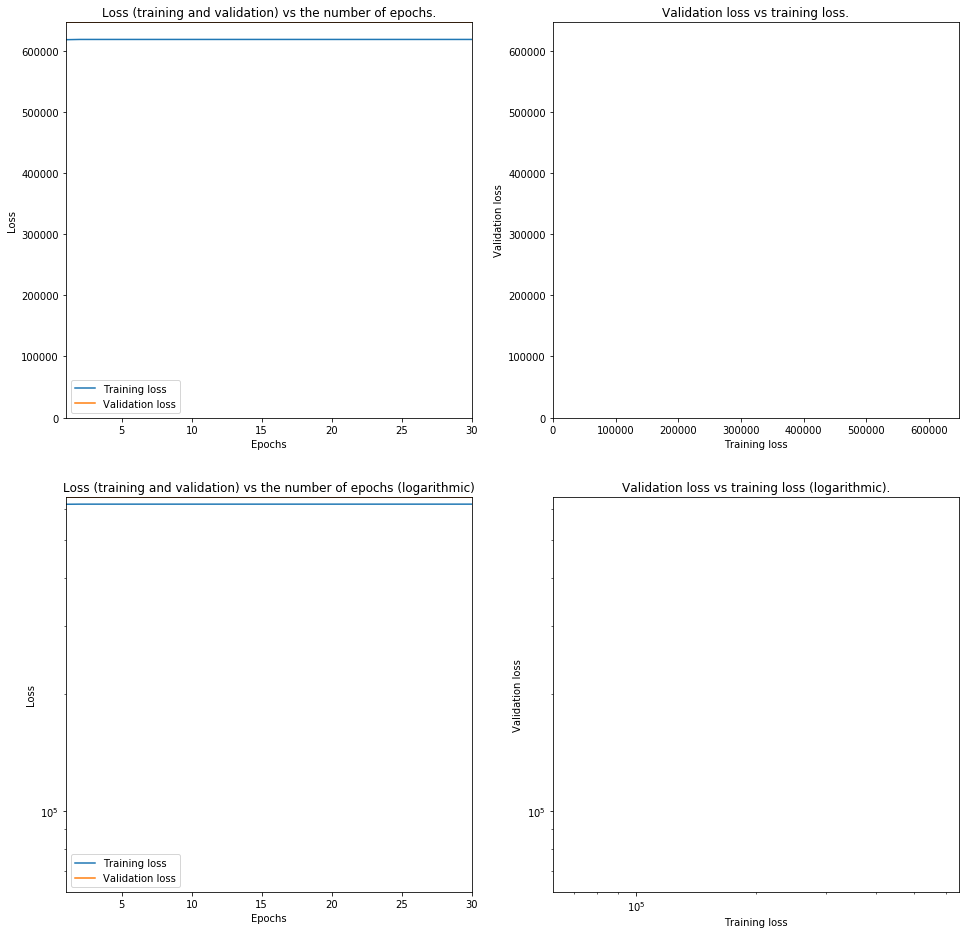

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 1)                 16        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[ 2.5584501e+01],
       [ 2.0658112e+00],
       [-5.3827536e-01],
       [-2.4247837e+01],
       [ 3.4694377e+03],
       [ 6.4562294e+01],
       [-6.5392891e+01],
       [-3.4693137e+03],
       [ 5.0000728e+05],
       [ 4.3138369e+03],
       [-4.3872163e+03],
       [-4.9995500e+05],
       [ 7.4047872e+07],
       [ 3.0085544e+05],
       [-3.0276684e+05],
       [-7.4046128e+07]], dtype=float32)]
Layer 1:  []


In [142]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

3.842458450537096e+19


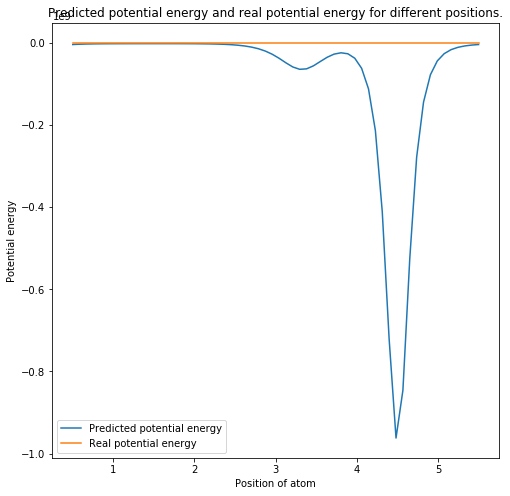

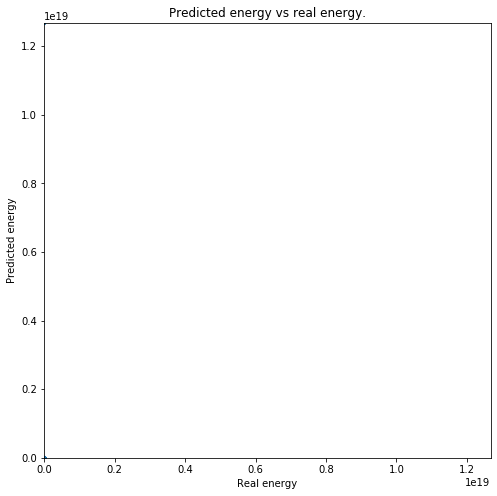

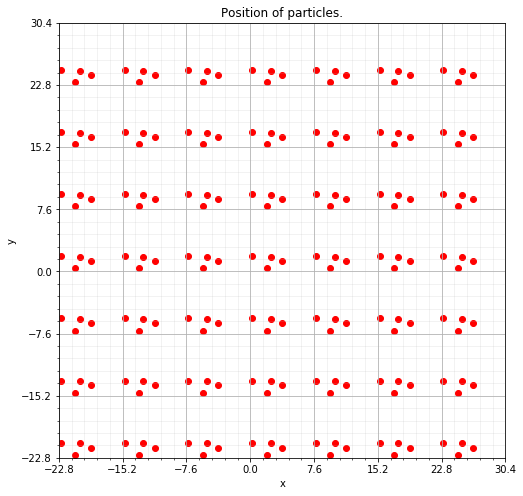

For index 8782 Predicted -1563934.2 was -0.048597706000000004


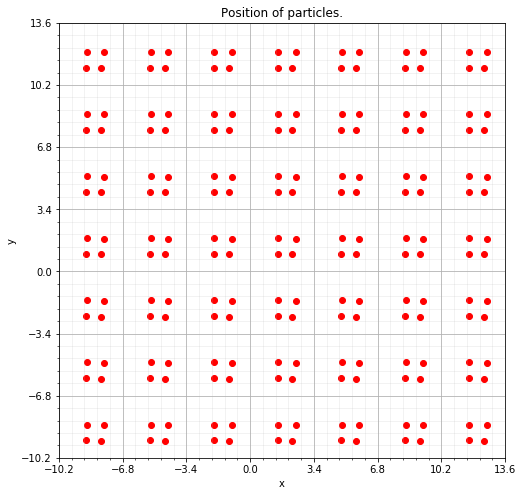

For index 710 Predicted -18332744.0 was -4.9470265967


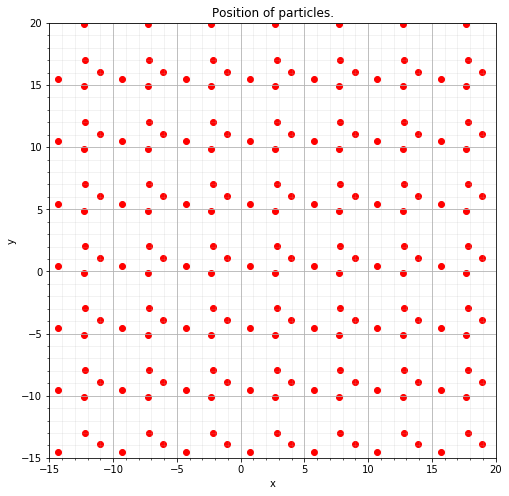

For index 1308 Predicted -1410736.1 was -0.0107693382


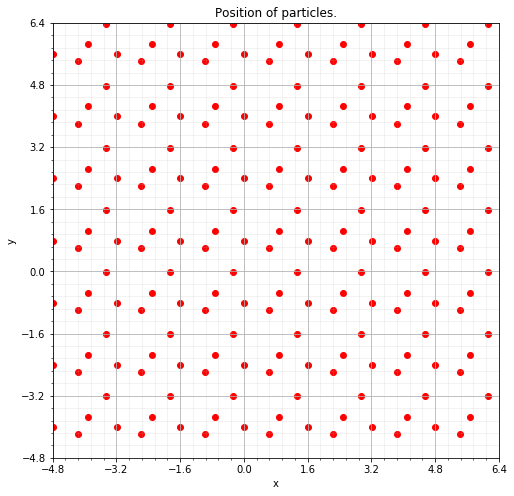

For index 22591 Predicted -102939990.0 was 93.4861035426


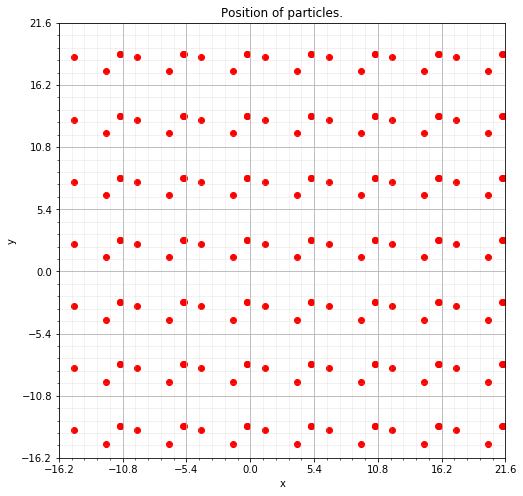

For index 19477 Predicted -798301900000.0 was -1.2610755299


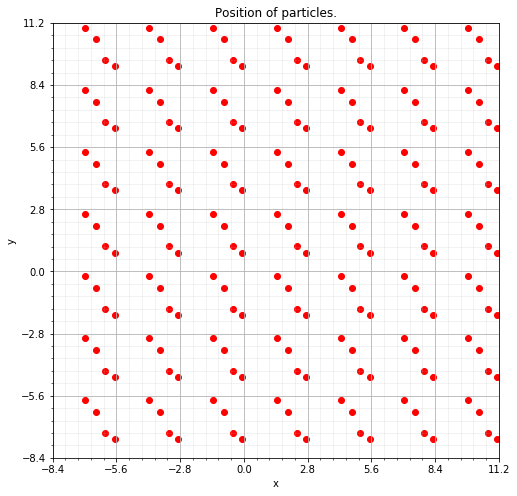

For index 7256 Predicted -100674696.0 was -3.5611577256


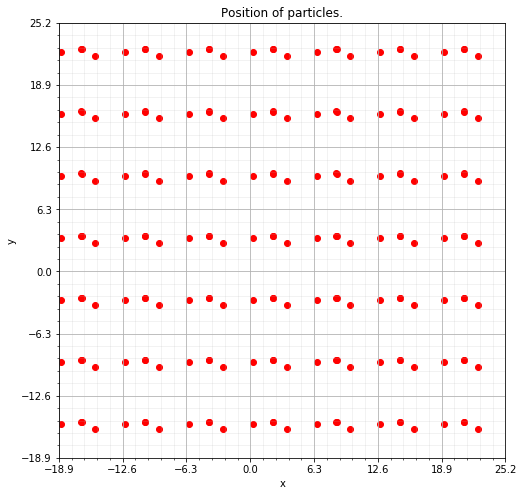

For index 31023 Predicted -807546100000.0 was -1.6081988207


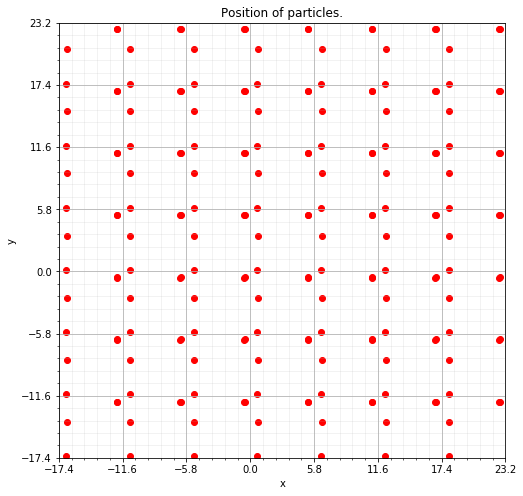

For index 8333 Predicted -477962960000.0 was -0.651287065


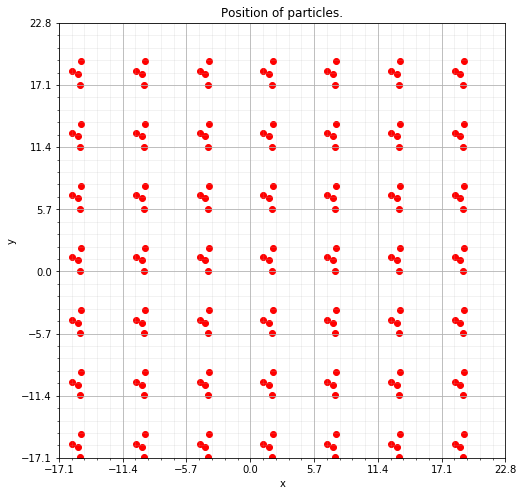

For index 10594 Predicted -38552748.0 was -2.9004048437


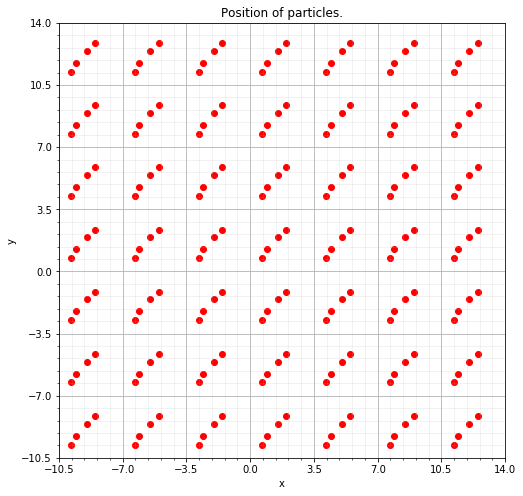

For index 25554 Predicted -97277780.0 was -3.0778812932


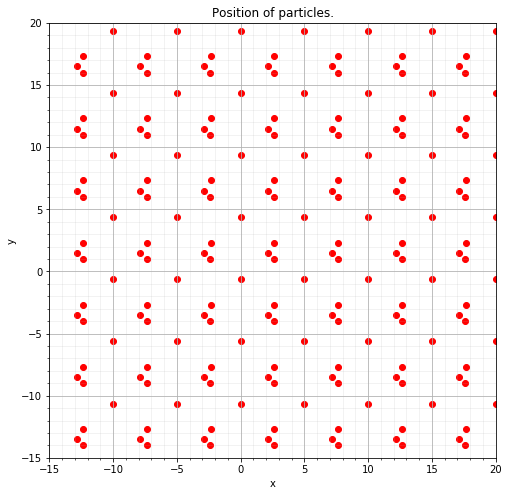

For index 12636 Predicted -18570892.0 was -1.3151148951
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
[array([[ 29.563461  ],
       [-23.666512  ],
       [ 18.94518   ],
       [-28.670338  ],
       [ 16.399529  ],
       [ -6.364651  ],
       [  5.5128164 ],
       [-15.934353  ],
       [ 12.544009  ],
       [ -1.7188815 ],
       [  0.9167708 ],
       [-13.383032  ],
       [ -0.3228442 ],
       [  1.1486595 ],
       [ -0.67470556],
       [ -0.28992522]], dtype=float32)]



In [94]:

print(evaluation)

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


# Finishing

In [95]:
for i in range(len(models)):
    model = models[i]['model']
    print(models[i]['name'])
    print(model.summary())
    print(models[i]['evaluation'])
    model.save(saveFolder + '/' + models[i]['name'] + str(models[i]['evaluation']) + '.h5')
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')

0LinearNetwork
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
7.167275091157822e+16

 

1LinearNetwork
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
3.842458450537096e+19

 



# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)